In [1]:
pip install networkx pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
import pandas as pd

In [3]:
nodes = pd.read_csv('instagram-IM-dataset/Instagram User Stats.csv')
edges = pd.read_csv('instagram-IM-dataset/Network for IC LT.txt', skiprows=1, header=None, sep=' ', names=['source', 'target', 'weight'])
edges['followers'] = (1/edges['weight']).astype(int)

In [4]:
nodes.head()

,id,pos,flr,flg,eg,er,fg,op
0,1,702,906,677,0.1891,6.070640,1.177860,14.8936
1,2,160,386,713,0.1950,6.260800,0.094127,16.9811
2,3,851,20400,3700,0.0664,0.717416,2.242440,38.2166
3,4,42,900,7500,0.0592,1.901230,7.643310,60.1626
4,5,50,486,4350,0.5112,16.409500,0.372900,61.9403


In [5]:
len(nodes)

70409

In [6]:
edges.head()

,source,target,weight,followers
0,1,2,0.0833,12
1,1,3,0.0500,20
2,2,69,0.0005,2000
3,2,72,0.0008,1250
4,2,77,0.0006,1666


In [7]:
len(edges)

1031348

In [8]:
# Plotting only the most important nodes

# get top 20 nodes by followers
top_nodes = nodes.sort_values('flr', ascending=False).head(20)['id']

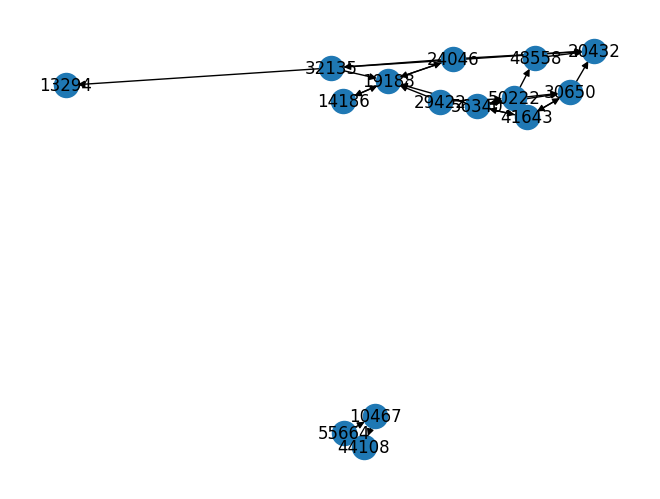

In [9]:
top_edges = edges[edges['source'].isin(top_nodes) & edges['target'].isin(top_nodes)]
top_graph = nx.from_pandas_edgelist(top_edges, 'source', 'target', ['followers'], create_using=nx.DiGraph())

# plot the graph
pos = nx.spring_layout(top_graph)
nx.draw(top_graph, pos, with_labels=True)

Even just visualizing the largest 20 users is too much for the plot to reasonably display. Let's try to narrow it down to a community first


In [10]:
G = nx.from_pandas_edgelist(edges, 'source', 'target', ['followers'])

In [11]:
# community detection over the network
from networkx.algorithms import community
communities = community.louvain_communities(G)

In [12]:
pd.DataFrame(
    [(i, len(c)) for i, c in enumerate(communities)],
    columns=['community', 'size']
).sort_values(
    'size', ascending=False
).head(50)


,community,size
2,2,16904
6,6,11777
11,11,11325
5,5,7016
7,7,6699
1,1,4145
4,4,3660
14,14,3184
0,0,2731
3,3,1247


In [13]:
def get_subset_graph(edges, community):
    """Grabs the relevant subgraph from an edge list."""
    return edges[edges['source'].isin(community) & edges['target'].isin(community)].copy(deep=True)

Let's compute the most influential members of a community. We are going to calculate the closeness_centrality of each member -- the closeness centrality is the avg length of the shortest path between that node and all other nodes in the community. 
The idea is the most influential members of a community has the fewest degrees of separation from everyone in their community. 

In [107]:
closeness = {}
for i, community in enumerate(communities):
    subset_graph_edges = get_subset_graph(edges, community)
    print(f'Community {i} has {len(subset_graph)} edges.')

    if len(subset_graph) < 100:
        # skip small communities
        continue

    subset_graph = nx.from_pandas_edgelist(subset_graph_edges, 'source', 'target', ['followers'])
    closeness.update( nx.closeness_centrality(subset_graph))

Community 0 has 408 edges.
Community 1 has 2731 edges.
Community 2 has 4145 edges.
Community 3 has 16904 edges.
Community 4 has 1247 edges.
Community 5 has 3660 edges.
Community 6 has 7016 edges.
Community 7 has 11777 edges.
Community 8 has 6699 edges.
Community 9 has 801 edges.
Community 10 has 2 edges.
Community 11 has 2 edges.
Community 12 has 2 edges.
Community 13 has 2 edges.
Community 14 has 2 edges.
Community 15 has 2 edges.
Community 16 has 2 edges.
Community 17 has 2 edges.
Community 18 has 2 edges.
Community 19 has 2 edges.
Community 20 has 2 edges.
Community 21 has 2 edges.
Community 22 has 2 edges.
Community 23 has 2 edges.
Community 24 has 2 edges.
Community 25 has 2 edges.
Community 26 has 2 edges.
Community 27 has 2 edges.
Community 28 has 2 edges.
Community 29 has 2 edges.
Community 30 has 2 edges.
Community 31 has 2 edges.
Community 32 has 2 edges.
Community 33 has 2 edges.
Community 34 has 2 edges.
Community 35 has 2 edges.
Community 36 has 2 edges.
Community 37 has 2

Let's now take a look at the nodes -- a part of the dataset is the engagement rate of existing followers and what percent of likes are from a non-follower. 

Given the current state of a user (number of followers, number of users they follow, attributes of who they follow, and their followers), let's predict how a post would behave. 

In [30]:
following_stats = edges.merge(
    nodes[['id', 'flr', 'flg']],
    left_on='target',
    right_on='id'
).groupby(
    'source'
).agg(
    # get avg followers and following
    avg_followers=('flr', 'mean'),
    avg_following=('flg', 'mean'),
    count=('id', 'count')
)

followers_stats = edges.merge(
    nodes[['id', 'flr', 'flg']],
    left_on='source',
    right_on='id'
).groupby(
    'target'
).agg(
    # get avg followers and following
    avg_followers=('flr', 'mean'),
    avg_following=('flg', 'mean'),
    count=('id', 'count')
)



In [31]:
following_stats.head()

,avg_followers,avg_following,count
source,,,
1,10393.000000,2206.500000,2
2,1327.250000,3165.416667,12
3,1723.679487,2154.500000,78
4,722.176471,2668.264706,34
5,913.857143,4061.142857,7


In [32]:
followers_stats.head()

,avg_followers,avg_following,count
target,,,
1,6850.000000,1450.250000,4
2,1099.416667,913.166667,12
3,8228.850000,1352.600000,20
4,1514.064453,1174.812500,512
5,36917.181818,1308.590909,22


In [108]:
full_df = (
    nodes
    .join(following_stats, on='id')
    .join(followers_stats, on='id', lsuffix='_following', rsuffix='_followers')
)

full_df['community_closeness'] = full_df['id'].map(closeness)


In [112]:
X_cols = [
    'flr', 'flg', 'community_closeness',
    'avg_followers_following', 'avg_following_following', 'count_following',
    'avg_followers_followers', 'avg_following_followers', 'count_followers'
]

y_col = 'er'

# plot a sample of 100 nodes
full_df[X_cols + [y_col]].corr()[y_col].to_dict()
# sample = nodes.sample(100)
# sample.corr()

{'flr': -0.08173792521352585,
 'flg': -0.3182836397653458,
 'community_closeness': -0.2275025503487497,
 'avg_followers_following': -0.07944514454327484,
 'avg_following_following': -0.20980840051034236,
 'count_following': -0.08502789015099871,
 'avg_followers_followers': 0.00042442968886600383,
 'avg_following_followers': -0.2706460664084599,
 'count_followers': -0.17695075434819563,
 'er': 1.0}

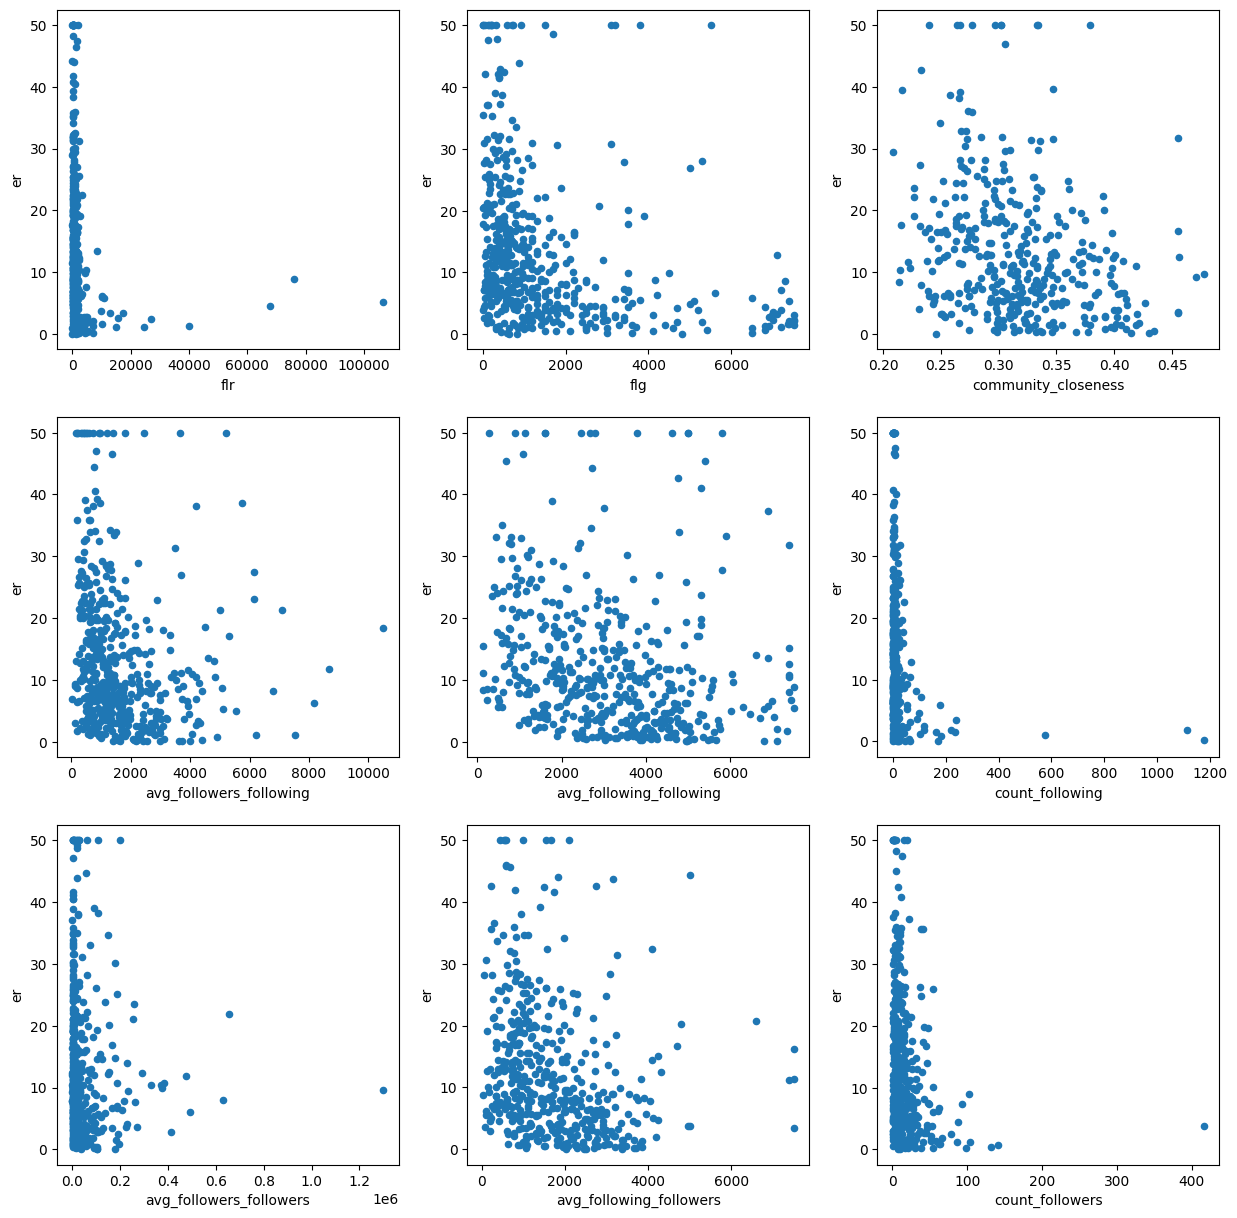

In [113]:
# create subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, x_col in enumerate(X_cols):
    full_df.sample(n=500).plot.scatter(x_col, y_col, ax=axes[i])

Not much of a clear correlation between the features and engagement rate; let's try to build a model and see if there are interactions that can be uncovered that way

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [131]:
full_df.fillna(0, inplace=True)
train, test = train_test_split(full_df, test_size=0.2)

In [122]:
X_train = train[X_cols]
y_train = train[y_col]
clf = LinearRegression()

In [138]:
def fit_and_score(clf, X, y):

    print(clf)

    clf.fit(X, y)
    score = r2_score(y, clf.predict(X))
    print(f'R2: {score}')

    cv_score = cross_val_score(clf, X, y, cv=5, scoring='r2')
    print(cv_score)
    return (clf, r2_score, cv_score)

In [139]:
clfs = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor]

In [142]:
results = []

for clf in clfs:
    results.append(fit_and_score(clf(), X_train, y_train))
    print('---')

LinearRegression()
R2: 0.1421732671566721
[0.13988657 0.14834219 0.13279915 0.14705555 0.13468888]
---
RandomForestRegressor()
R2: 0.9045553536925064
[0.30710077 0.32631636 0.31310846 0.31528736 0.30559103]
---
GradientBoostingRegressor()
R2: 0.3272665153974529
[0.30353908 0.32241739 0.311661   0.30966441 0.30807275]
---


As users gain/lose followers and as they follow and unfollow members, the nature of the graph changes (centrality and other follower count interactions change). Additionally, we can recompute the communities which each user is a part of and centrality would change again. But utilizing this, we can estimate how an account would expect to see their engatement rates (which can translate to virality) change as their position in the graph changes. 

Note: 

The model r2-score is definately on the low side. But this is more a demonstration of possible signals to incorporate instead of getting to a model that is fully predictive. 